# Overview
We take images and turn them into features by performing a few simple analyses. We focus initially on colors and then on shapes

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/AI ESP"

In [3]:
%cd "/content/gdrive/My Drive/AI ESP"

/content/gdrive/My Drive/AI ESP


In [4]:
pwd

'/content/gdrive/My Drive/AI ESP'

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'viridis' # grayscale looks better

In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
from skimage.io import imread as imread
from skimage.util import montage as montage2d
from skimage.color import label2rgb
from PIL import Image
base_dir = Path('.') / 'input' / 'skin-cancer-mnist-ham10000'

# Overview
Load and process data

In [7]:
print(base_dir)
image_overview_df = pd.read_csv(base_dir / 'HAM10000_metadata.csv')
all_image_ids = {c_path.stem: c_path for c_path in base_dir.glob('**/*.jpg')}
image_overview_df['image_path'] = image_overview_df['image_id'].map(all_image_ids.get)
image_overview_df.dropna(inplace=True) # remove values that are missing
print(image_overview_df.shape[0], 'image, recipe pairs loaded')
image_overview_df.sample(3)

input/skin-cancer-mnist-ham10000
9958 image, recipe pairs loaded


lesion_id  ...                                         image_path
1599  HAM_0003280  ...  input/skin-cancer-mnist-ham10000/ham10000_imag...
5295  HAM_0001578  ...  input/skin-cancer-mnist-ham10000/ham10000_imag...
6180  HAM_0004751  ...  input/skin-cancer-mnist-ham10000/ham10000_imag...

[3 rows x 8 columns]

## Examining what we have

In [8]:
image_overview_df.drop(['age'], axis=1).describe()

lesion_id  ...                                         image_path
count          9958  ...                                               9958
unique         7418  ...                                               9958
top     HAM_0003789  ...  input/skin-cancer-mnist-ham10000/ham10000_imag...
freq              6  ...                                                  1

[4 rows x 7 columns]

## What diseases do we have?
In medicine the `dx` is an abbreviation for diagnosis and here these are short for
### From the original text about the dataset we have this quite technical medical detail
Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions:
- Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)
- basal cell carcinoma (bcc)
- benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)
- dermatofibroma (df)
- melanoma (mel)
- melanocytic nevi (nv) 
- vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).
### Simplified
- nv $\rightarrow$ melanocytic nevi $\rightarrow$ 0
- mel $\rightarrow$ melanoma $\rightarrow$ 1
- bcc $\rightarrow$ basal cell carcinoma $\rightarrow$ 2
- akiec $\rightarrow$ Actinic keratoses and intraepithelial carcinoma $\rightarrow$ 3
- vasc  $\rightarrow$ vascular lesions $\rightarrow$ 4
- bkl $\rightarrow$ benign keratosis-like lesions $\rightarrow$ 5
- df $\rightarrow$ dermatofibroma $\rightarrow$ 6

In [9]:
dx_name_dict = {
    'nv': 'melanocytic nevi',
    'mel': 'melanoma',
    'bcc': 'basal cell carcinoma',
    'akiec': 'Actinic keratoses and intraepithelial carcinoma',
    'vasc': 'vascular lesions',
    'bkl': 'benign keratosis-like',
    'df': 'dermatofibroma'
}
image_overview_df['dx_name'] = image_overview_df['dx'].map(dx_name_dict.get)
dx_name_id_dict = {name: id for id, name in enumerate(dx_name_dict.keys())}
image_overview_df['dx_id'] = image_overview_df['dx'].map(dx_name_id_dict.get).astype(int)
image_overview_df.sample(3)

lesion_id      image_id  ...                dx_name dx_id
8043  HAM_0002605  ISIC_0034164  ...       melanocytic nevi     0
4402  HAM_0004250  ISIC_0032499  ...       melanocytic nevi     0
260   HAM_0001309  ISIC_0034037  ...  benign keratosis-like     5

[3 rows x 10 columns]

In [10]:
image_overview_df['dx_name'].value_counts()

melanocytic nevi                                   6660
melanoma                                           1111
benign keratosis-like                              1089
basal cell carcinoma                                514
Actinic keratoses and intraepithelial carcinoma     327
vascular lesions                                    142
dermatofibroma                                      115
Name: dx_name, dtype: int64

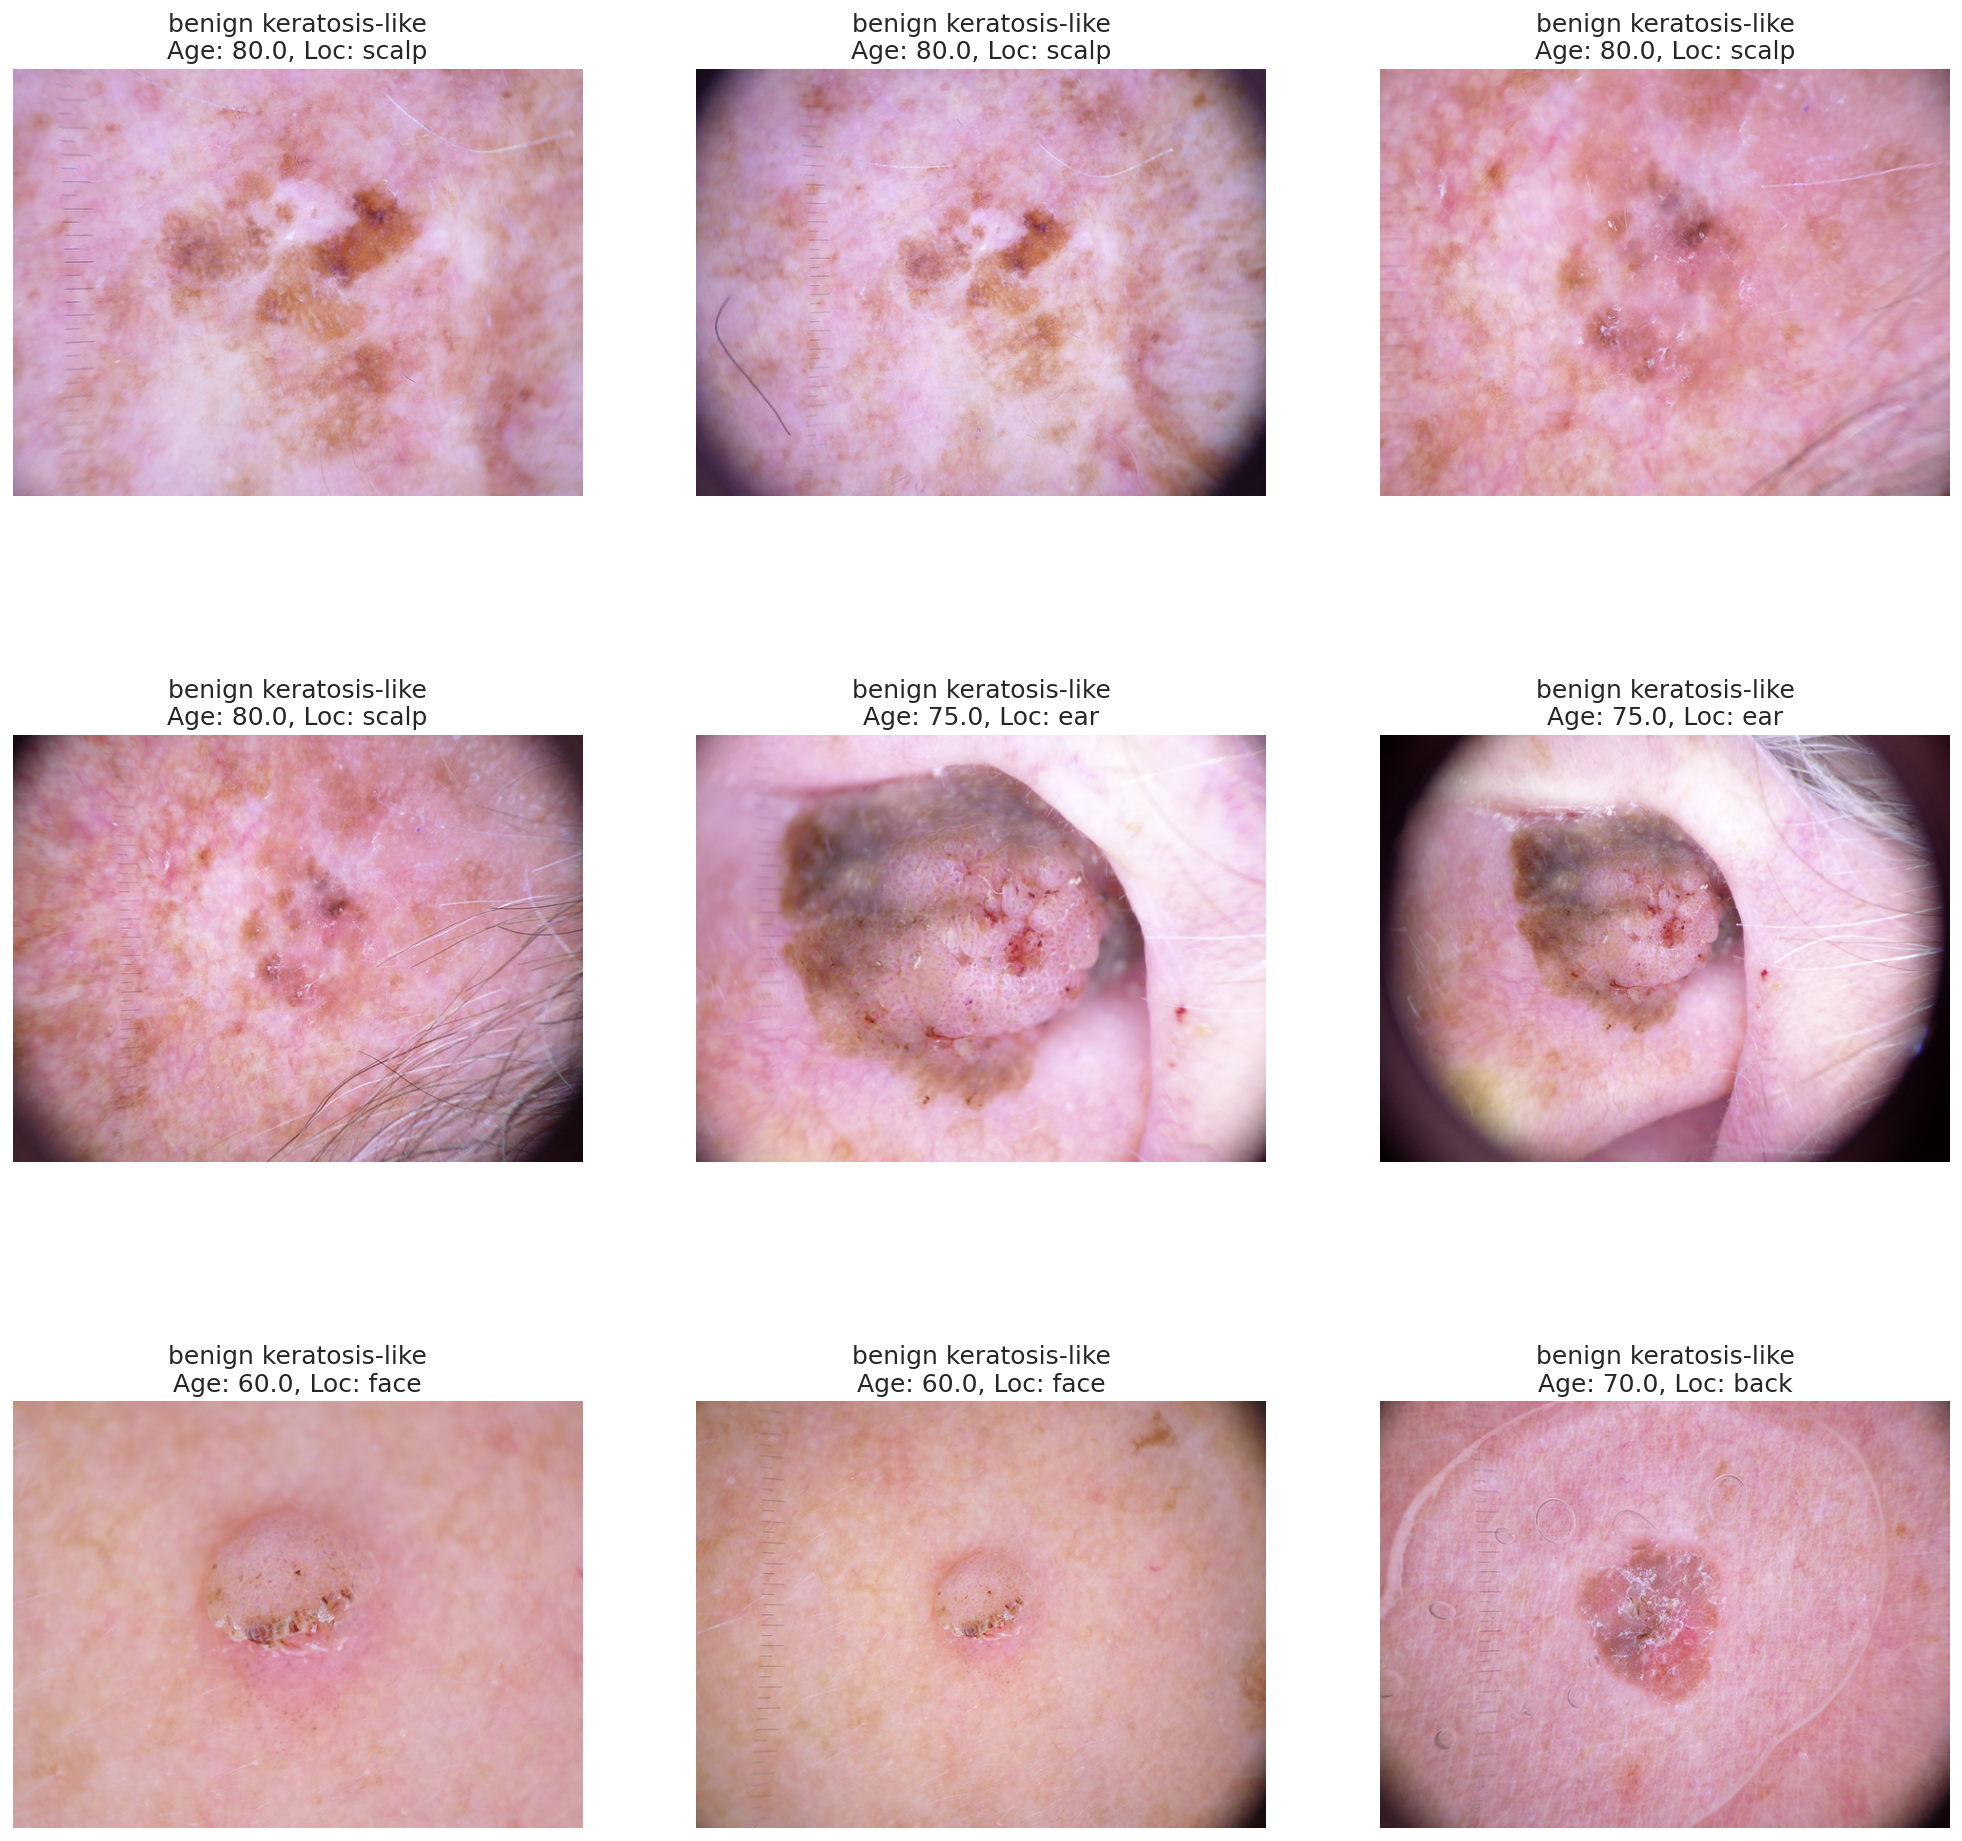

In [11]:
fig, m_axs = plt.subplots(3, 3, figsize=(20, 20))
for c_ax, (_, c_row) in zip(m_axs.flatten(), 
                            image_overview_df.head(9).iterrows()):
    c_ax.imshow(imread(c_row['image_path']))
    c_ax.set_title('{dx_name}\nAge: {age}, Loc: {localization}'.format(**c_row))
    c_ax.axis('off')

# Create Color Features
We start with simple color features by grouping the image into 

In [12]:
test_row = image_overview_df.iloc[1]
print(test_row)

lesion_id                                             HAM_0000118
image_id                                             ISIC_0025030
dx                                                            bkl
dx_type                                                     histo
age                                                            80
sex                                                          male
localization                                                scalp
image_path      input/skin-cancer-mnist-ham10000/ham10000_imag...
dx_name                                     benign keratosis-like
dx_id                                                           5
Name: 1, dtype: object


### Reduce the number of colors
Currently we have $ \underbrace{2^8}_{\textrm{8-bit}}$ and $\underbrace{3 \textrm{channel}}_{\textrm{Red, Green, Blue}}$. This means we have $2^{8^3} \rightarrow 16,581,375$ different colors. 
We can convert the image to 8-bit format to reduce the number of colors by a factor of 65536

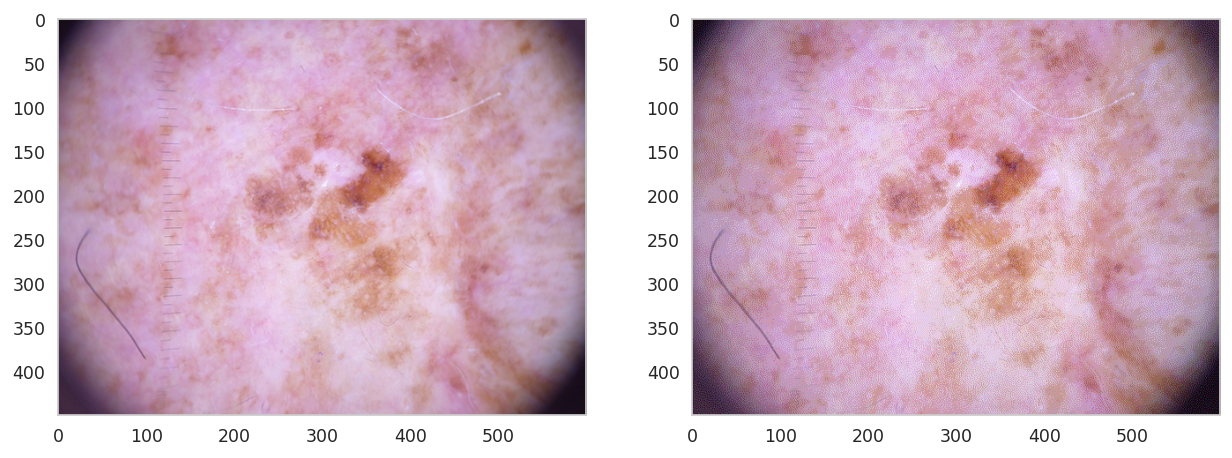

In [13]:
test_image = Image.open(test_row['image_path']) # normal image
# convert to 8bit color (animated GIF) and then back
web_image = test_image.convert('P', palette='WEB', dither=None)
few_color_image = web_image.convert('RGB')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(test_image)
ax2.imshow(few_color_image)

In [14]:
print('Unique colors before', len(set([tuple(rgb) for rgb in np.array(test_image).reshape((-1, 3))])))
print('Unique colors after', len(set([tuple(rgb) for rgb in np.array(few_color_image).reshape((-1, 3))])))

Unique colors before 49451
Unique colors after 61


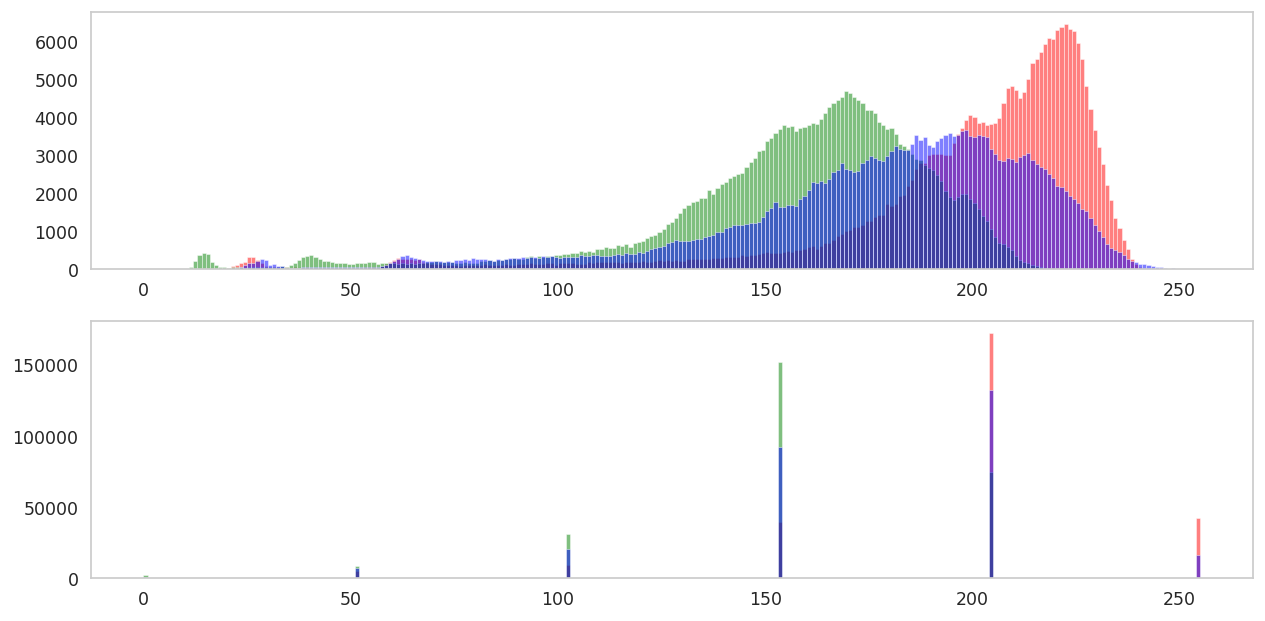

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
for c_channel, c_name in enumerate(['red', 'green', 'blue']):
    ax1.hist(np.array(test_image)[:, :, c_channel].ravel(), 
             color=c_name[0], 
             label=c_name, 
             bins=np.arange(256), 
             alpha=0.5)
    ax2.hist(np.array(few_color_image)[:, :, c_channel].ravel(), 
             color=c_name[0], 
             label=c_name, 
             bins=np.arange(256), 
             alpha=0.5)

# How do the colors look?

In [16]:
idx_to_color = np.array(web_image.getpalette()).reshape((-1, 3))/255.0

Text(0, 0.5, 'Pixel Count')

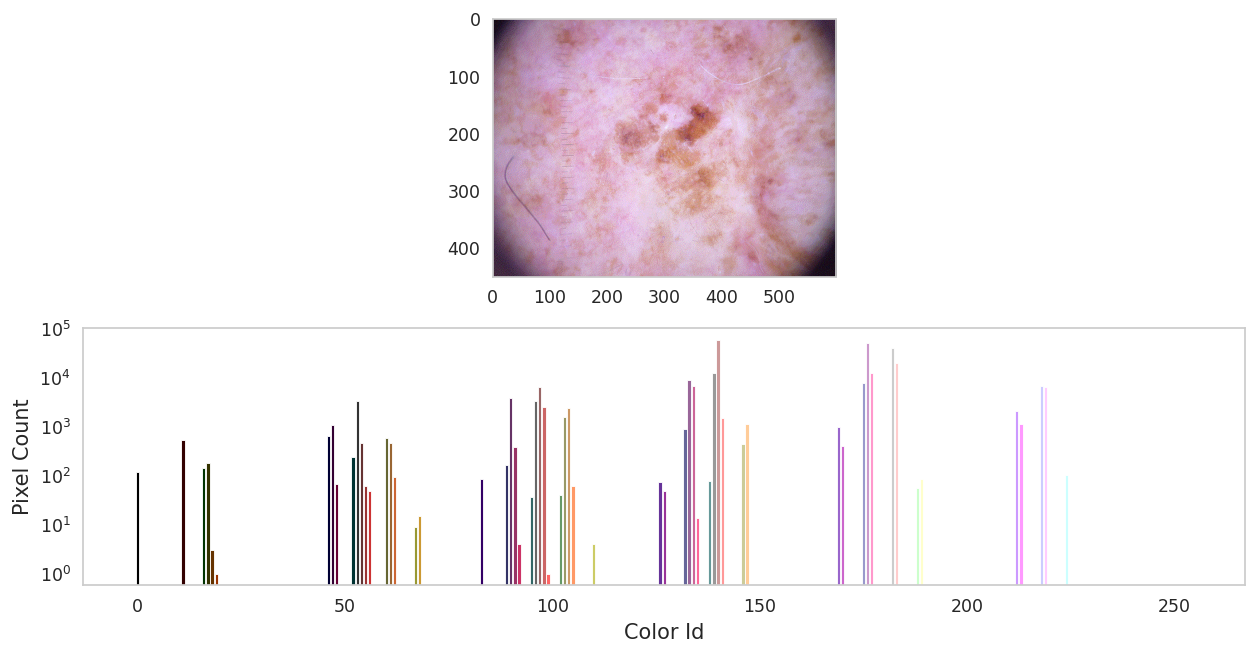

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.imshow(few_color_image)
counts, bins = np.histogram(web_image, bins=np.arange(256))
for i in range(counts.shape[0]):
    ax2.bar(bins[i], counts[i], color=idx_to_color[i])
ax2.set_yscale('log')
ax2.set_xlabel('Color Id')
ax2.set_ylabel('Pixel Count')

# Calculate for Many Images

In [18]:
def color_count_feature(in_path):
    raw_image = Image.open(in_path) 
    web_image = raw_image.convert('P', palette='WEB', dither=None)
    counts, bins = np.histogram(np.array(web_image).ravel(), bins=np.arange(256))
    return counts*1.0/np.prod(web_image.size) # normalize output

## Calculate a few test images

In [19]:
%%time
image_subset_df = image_overview_df.sample(100).copy()
image_subset_df['color_features'] = image_subset_df['image_path'].map(color_count_feature)
image_subset_df.sample(3)

CPU times: user 2.34 s, sys: 84.4 ms, total: 2.43 s
Wall time: 25.2 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'Frequency')

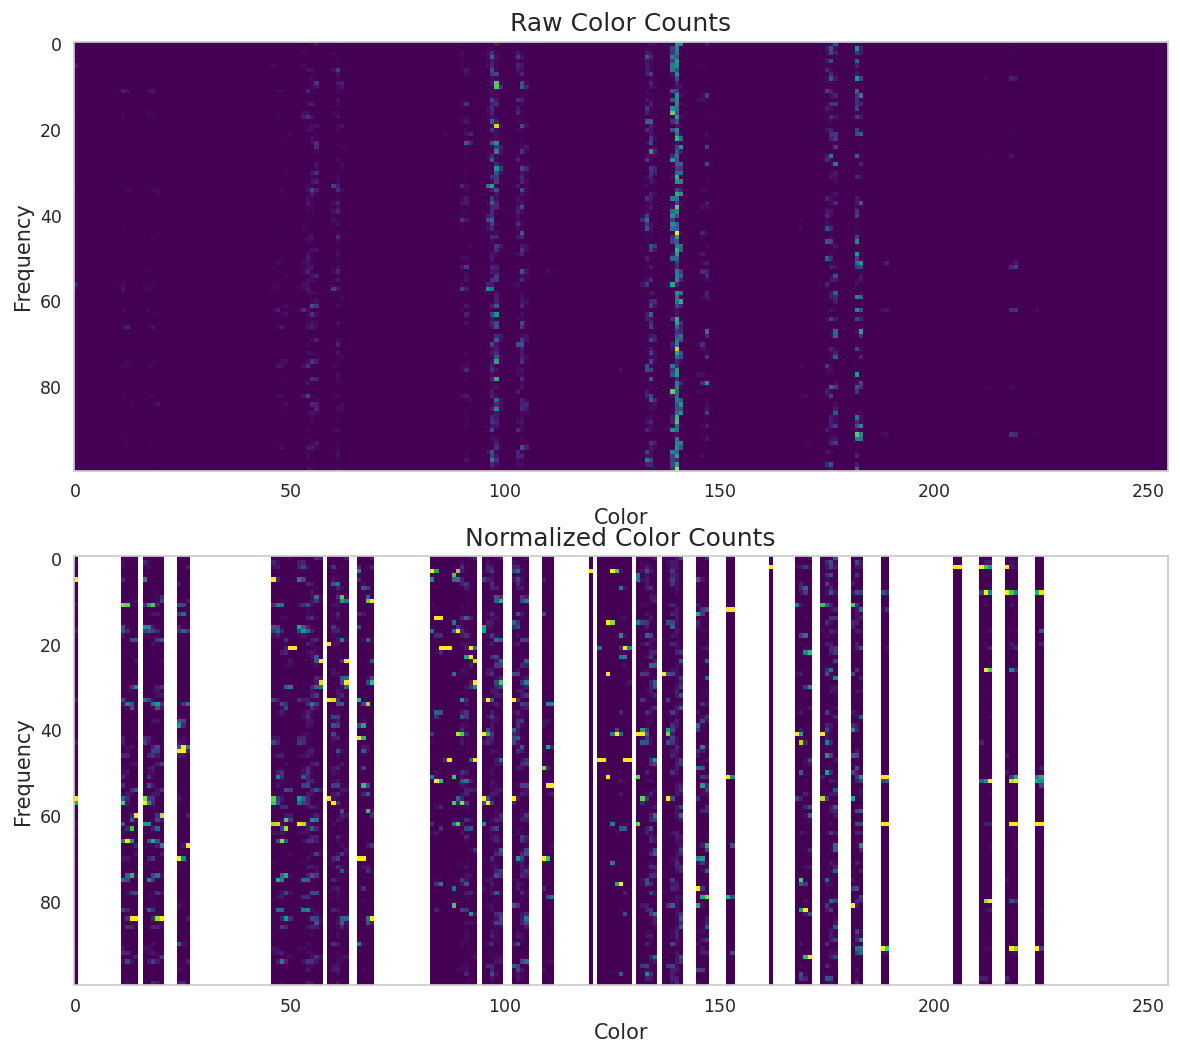

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
combined_features = np.stack(image_subset_df['color_features'].values, 0)
ax1.imshow(combined_features)
ax1.set_title('Raw Color Counts')
ax1.set_xlabel('Color')
ax1.set_ylabel('Frequency')
color_wise_average = np.tile(np.mean(combined_features, 0, keepdims=True), (combined_features.shape[0], 1))
ax2.imshow(combined_features/color_wise_average, vmin=0.05, vmax=20)
ax2.set_title('Normalized Color Counts')
ax2.set_xlabel('Color')
ax2.set_ylabel('Frequency')

## PCA Components
We can use a tool called principle component analysis to show the images in features

In [21]:
from sklearn.decomposition import PCA
xy_pca = PCA(n_components=2)
xy_coords = xy_pca.fit_transform(combined_features)
image_subset_df['x'] = xy_coords[:, 0]
image_subset_df['y'] = xy_coords[:, 1]

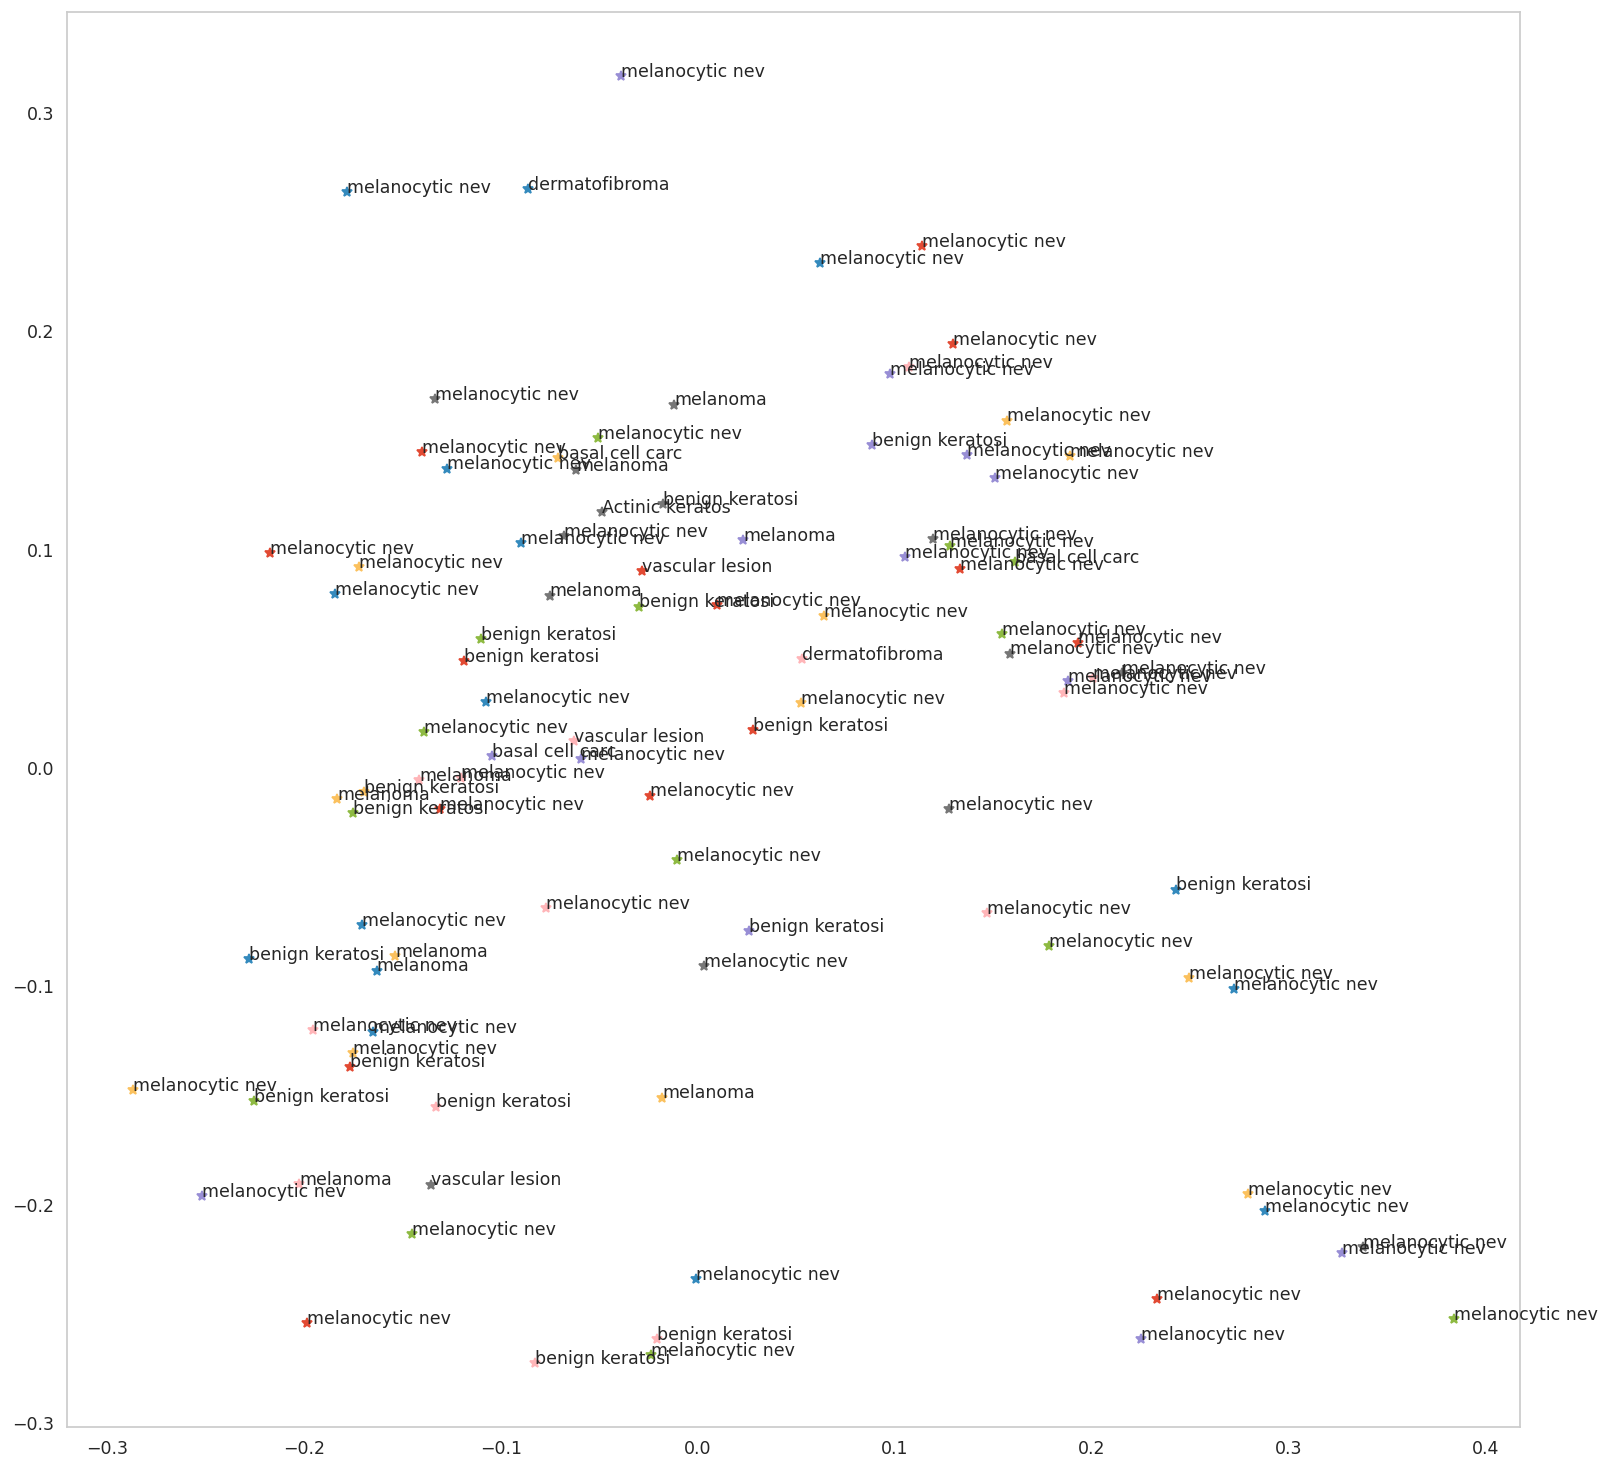

In [22]:
fig, ax1 = plt.subplots(1,1, figsize=(15, 15))
for _, c_row in image_subset_df.iterrows():
    ax1.plot(c_row['x'], c_row['y'], '*')
    ax1.text(s=c_row['dx_name'][:15], x=c_row['x'], y=c_row['y'])

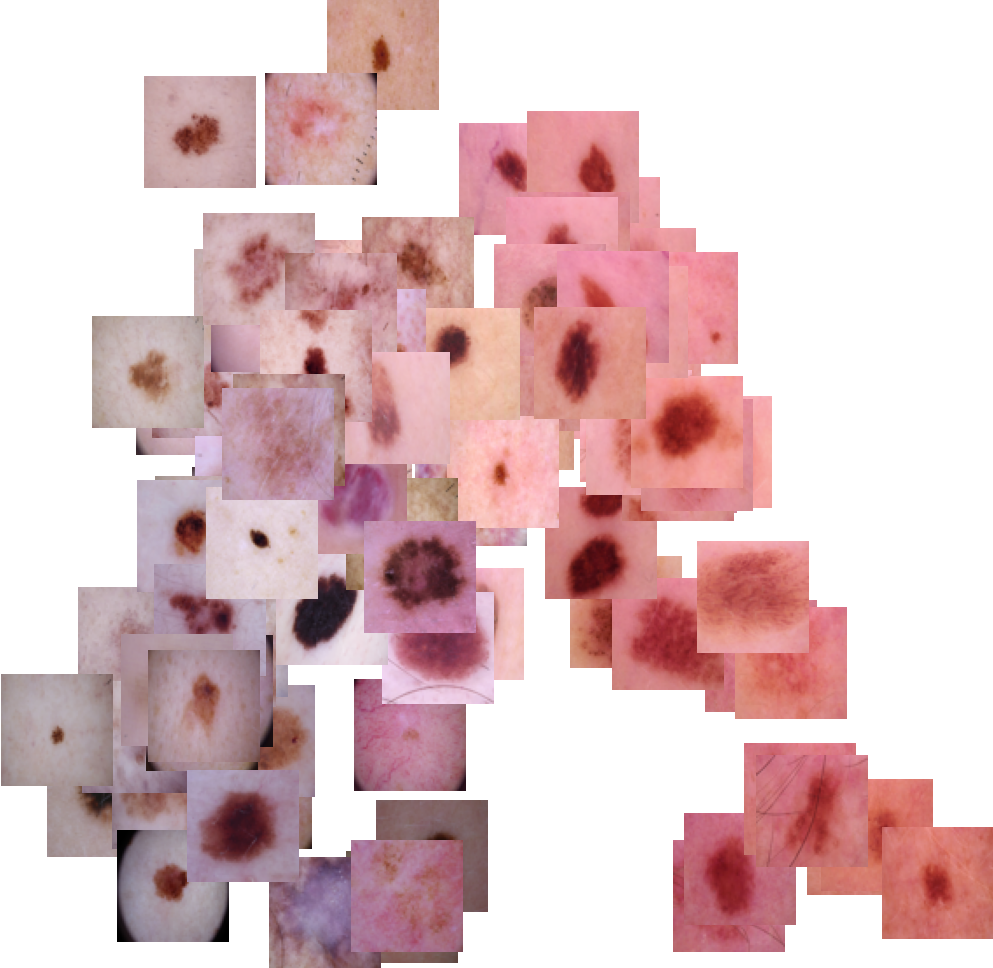

In [23]:
def show_xy_images(in_df, image_zoom=1):
    fig, ax1 = plt.subplots(1,1, figsize=(10, 10))
    artists = []
    for _, c_row in in_df.iterrows():
        c_img = Image.open(c_row['image_path']).resize((64, 64))
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (c_row['x'], c_row['y']), xycoords='data', frameon=False)
        artists.append(ax1.add_artist(ab))
    ax1.update_datalim(in_df[['x', 'y']])
    ax1.autoscale()
    ax1.axis('off')
show_xy_images(image_subset_df)

## TSNE Representation
Rather than using simple PCA we can come up with a fancier representation called [TSNE](https://lvdmaaten.github.io/tsne/)

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(n_iter=250, verbose=True)
xy_coords = tsne.fit_transform(combined_features)
image_subset_df['x'] = xy_coords[:, 0]
image_subset_df['y'] = xy_coords[:, 1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.183467
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.540798
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


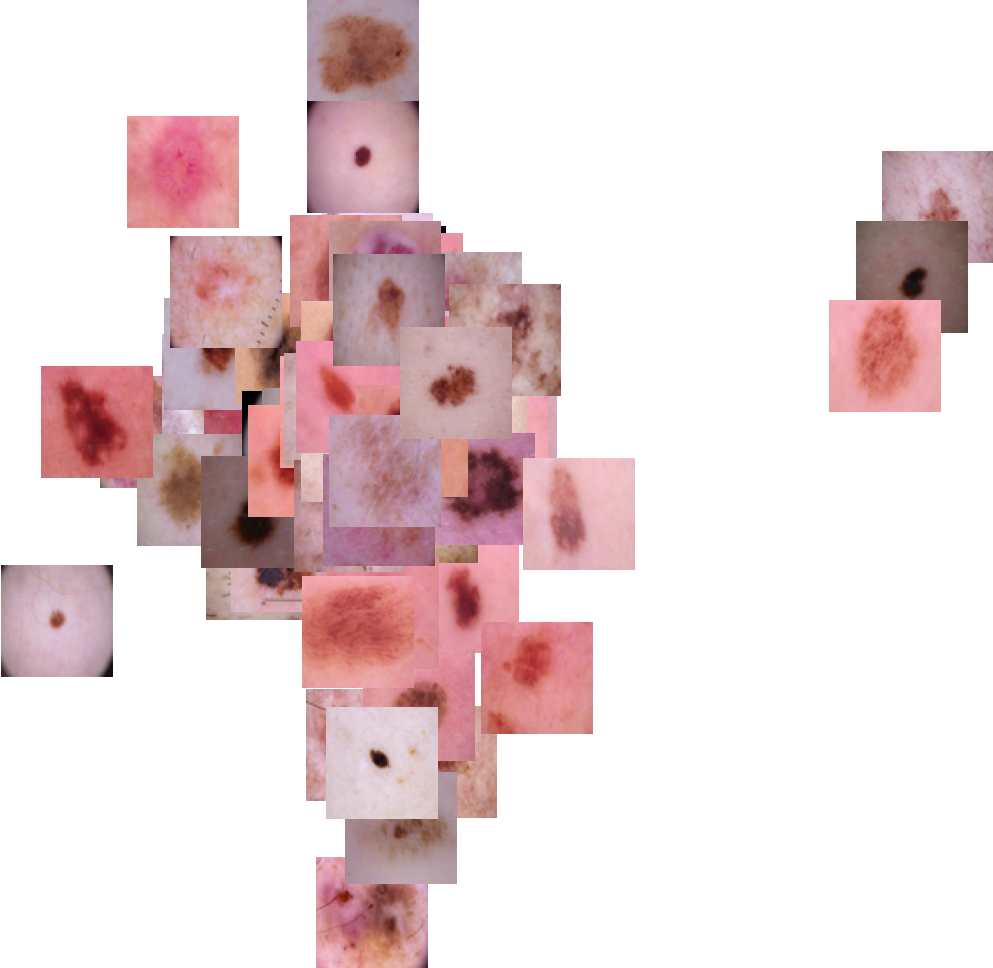

In [25]:
show_xy_images(image_subset_df)

## Calculate for all images

In [26]:
%%time
image_overview_df['color_features'] = image_overview_df['image_path'].map(color_count_feature).map(lambda x: x.tolist())
image_overview_df.sample(3)

CPU times: user 3min 53s, sys: 7.67 s, total: 4min 1s
Wall time: 40min 12s


In [27]:
image_overview_df['image_path'] = image_overview_df['image_path'].map(str)

In [28]:
image_overview_df.to_json('color_features.json')

In [29]:
!ls -lh

total 282M
-rw------- 1 root root  16M Jun 10 12:02 color_features.json
-rw------- 1 root root 3.4M Jun 10 11:27 extracting-image-features.ipynb
-rw------- 1 root root 193M Jun  9 09:01 full_skin_cancer_model.h5
drwx------ 4 root root 4.0K Jun  9 04:29 input
-rw------- 1 root root   63 Jun  8 17:15 kaggle.json
-rw------- 1 root root  71M Jun  9 08:37 skin_cancer_detector_weights.best.hdf5
